# Taller de Carga y Exploración Simple de de Datos


In [1]:
try:
    import google.colab
    !pip uninstall matplotlib -y
    !pip install -q condacolab
    !apt-get install unrar-free
    
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

In [2]:
try:
    import google.colab
    !git clone https://github.com/zorzalerrante/aves.git aves_git
    !mamba env update --name base --file aves_git/environment-colab.yml
except ModuleNotFoundError:
    pass

In [3]:
try:
    import google.colab
    !cd aves_git && make download-external
    !cd ..
except ModuleNotFoundError:
    pass

In [4]:
import sys
from pathlib import Path

AVES_ROOT = Path("..") if not 'google.colab' in sys.modules else Path("aves_git")
DATA_PATH = AVES_ROOT / "data" / "external"
DATA_PATH

PosixPath('../data/external')

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.utils import deaccent

sns.set(
    style="whitegrid", context="paper", font_scale=0.8, font="Fira Sans Extra Condensed"
)
mpl.rcParams["figure.dpi"] = 120


Para entender la CASEN:

http://observatorio.ministeriodesarrollosocial.gob.cl/storage/docs/casen/2017/Libro_de_Codigos_Casen_2017.pdf
http://observatorio.ministeriodesarrollosocial.gob.cl/storage/docs/casen/2020/Libro_de_codigos_Base_de_Datos_Casen_en_Pandemia_2020.pdf

Códigos de comunas:
http://www.subdere.gov.cl/documentacion/c%C3%B3digos-%C3%BAnicos-territoriales-actualizados-al-06-de-septiembre-2018

In [6]:
casen = pd.read_stata(DATA_PATH / "casen_2017/Casen 2017.dta", convert_categoricals=False)
casen.head()


,folio,o,id_vivienda,hogar,region,provincia,comuna,zona,expr,expc,...,hh_d_estado,hh_d_servbas,hh_d_entorno,hh_d_accesi,hh_d_medio,hh_d_appart,hh_d_tsocial,hh_d_seg,pobreza_multi_4d,pobreza_multi_5d
0,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN
1,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN
3,1.101100e+11,2.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN
4,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,1.0,1.0,1.0,0.0,1.0,NaN,1.0,0.0,0.0,NaN


In [7]:
comunas = casen["comuna"].unique().astype(int)
comunas


array([ 1101,  1107,  1401,  1402,  1404,  1405,  2101,  2102,  2103,
        2104,  2201,  2203,  2301,  2302,  3101,  3102,  3103,  3201,
        3202,  3301,  3302,  3303,  3304,  4101,  4102,  4103,  4104,
        4105,  4106,  4201,  4202,  4203,  4204,  4301,  4302,  4303,
        4304,  4305,  5101,  5102,  5103,  5105,  5107,  5109,  5301,
        5302,  5303,  5304,  5401,  5402,  5403,  5404,  5405,  5501,
        5502,  5503,  5504,  5506,  5601,  5602,  5603,  5604,  5605,
        5606,  5701,  5702,  5703,  5704,  5705,  5706,  5801,  5802,
        5803,  5804,  6101,  6102,  6103,  6104,  6105,  6106,  6107,
        6108,  6109,  6110,  6111,  6112,  6113,  6114,  6115,  6116,
        6117,  6201,  6202,  6203,  6204,  6205,  6206,  6301,  6302,
        6303,  6304,  6305,  6306,  6307,  6308,  6309,  6310,  7101,
        7102,  7103,  7104,  7105,  7106,  7107,  7108,  7109,  7110,
        7201,  7202,  7203,  7301,  7302,  7303,  7304,  7305,  7306,
        7307,  7308,

In [8]:
len(comunas)


324

In [9]:
casen_2020 = pd.read_stata(
    DATA_PATH / "casen_2020/Casen en Pandemia 2020 STATA.dta"
)
casen_2020.head()


/home/egraells/miniconda3/envs/aves/lib/python3.8/site-packages/pandas/io/stata.py:1457: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


,folio,o,id_persona,id_vivienda,region,provincia,comuna,zona,area,segmento,...,v27,v28,v29,hacinamiento,nhog_viv,indsan,ten_viv,ten_viv_f,iae,iai
0,1.101100e+11,1,5,1.101100e+09,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001,...,1,NaN,NaN,"Sin hacinamiento (menos de 2,5 personas por do...",1,Deficitario,Arrendada,Tenencia informal,Sin allegamiento externo,sin allegamiento interno
1,1.101100e+11,2,6,1.101100e+09,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001,...,1,NaN,NaN,"Sin hacinamiento (menos de 2,5 personas por do...",1,Deficitario,Arrendada,Tenencia informal,Sin allegamiento externo,sin allegamiento interno
2,1.101100e+11,2,31,1.101100e+09,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001,...,1,NaN,NaN,"Hacinamiento medio (entre 2,5 y 3,49 personas ...",1,Aceptable,Arrendada,Tenencia formal,Sin allegamiento externo,sin allegamiento interno
3,1.101100e+11,1,32,1.101100e+09,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001,...,1,NaN,NaN,"Hacinamiento medio (entre 2,5 y 3,49 personas ...",1,Aceptable,Arrendada,Tenencia formal,Sin allegamiento externo,sin allegamiento interno
4,1.101100e+11,3,30,1.101100e+09,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001,...,1,NaN,NaN,"Hacinamiento medio (entre 2,5 y 3,49 personas ...",1,Aceptable,Arrendada,Tenencia formal,Sin allegamiento externo,sin allegamiento interno


In [10]:
elecciones = pd.read_csv(
    DATA_PATH / "presidenciales_2021/Servel_20211121_PRESIDENCIALES_CHILE.csv",
    sep=";",
)
elecciones.head()


,eleccion_id,eleccion_nombre,region_id,region_nombre,provincia_id,provincia_nombre,comuna_id,comuna_nombre,circele_id,circele_nombre,...,codigo_colegio,nombre_colegio,sede_colegio,cs_id,cs,distrito_id,distrito,lista,pacto,partido_politico
0,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,CONVERGENCIA SOCIAL ...
1,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,PARTIDO REPUBLICANO DE CHILE ...
2,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,PARTIDO DEMOCRATA CRISTIANO ...
3,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,EVOLUCION POLITICA ...
4,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,UNION PATRIOTICA ...


In [11]:
codes = pd.read_excel(
    DATA_PATH / "CUT_2018_v04.xls"
)
codes


,Código Región,Nombre Región,Abreviatura Región,Código Provincia,Nombre Provincia,Código Comuna 2018,Nombre Comuna
0,1,Tarapacá,TPCA,11,Iquique,1101,Iquique
1,1,Tarapacá,TPCA,11,Iquique,1107,Alto Hospicio
2,1,Tarapacá,TPCA,14,Tamarugal,1401,Pozo Almonte
3,1,Tarapacá,TPCA,14,Tamarugal,1402,Camiña
4,1,Tarapacá,TPCA,14,Tamarugal,1403,Colchane
...,...,...,...,...,...,...,...
341,16,Ñuble,NUBLE,163,Punilla,16301,San Carlos
342,16,Ñuble,NUBLE,163,Punilla,16302,Coihueco
343,16,Ñuble,NUBLE,163,Punilla,16303,Ñiquén
344,16,Ñuble,NUBLE,163,Punilla,16304,San Fabián


In [12]:
elecciones.columns

Index(['eleccion_id', 'eleccion_nombre', 'region_id', 'region_nombre',
       'provincia_id', 'provincia_nombre', 'comuna_id', 'comuna_nombre',
       'circele_id', 'circele_nombre', 'local_id', 'local_nombre', 'mesa_id',
       'mesas_fusionadas', 'mesa_electores', 'mesa_numero', 'tipomesa',
       'mesa_descuadrada_preliminar', 'mesa_descuadrada_provisorio',
       'candidato', 'votos_preliminar_string', 'votos_provisorio_string',
       'nvoto', 'electo', 'codigo_colegio', 'nombre_colegio', 'sede_colegio',
       'cs_id', 'cs', 'distrito_id', 'distrito', 'lista', 'pacto',
       'partido_politico'],
      dtype='object')

In [13]:
elecciones["votos_preliminar_string"].astype(int)


ValueError: invalid literal for int() with base 10: '                                                                                                    '

In [14]:
elecciones["votos_preliminar_string_strip"] = (
    elecciones["votos_preliminar_string"].str.strip().str.replace(r"^$", "0").astype(int)
)


/tmp/ipykernel_5740/1964033267.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  elecciones["votos_preliminar_string"].str.strip().str.replace(r"^$", "0").astype(int)


In [15]:
elecciones["votos_preliminar_string_strip"].describe()


count    513029.000000
mean         41.236916
std          56.684928
min           0.000000
25%           3.000000
50%          17.000000
75%          45.000000
max         744.000000
Name: votos_preliminar_string_strip, dtype: float64

In [16]:
elecciones.groupby("candidato")["votos_preliminar_string_strip"].sum()


candidato
EDUARDO ARTES BRICHETTI                                                                                  102493
FRANCO PARISI FERNANDEZ                                                                                  898407
GABRIEL BORIC FONT                                                                                      1796664
JOSE ANTONIO KAST RIST                                                                                  1954053
MARCO ENRIQUEZ-OMINAMI GUMUCIO                                                                           533657
SEBASTIAN SICHEL RAMIREZ                                                                                 894800
Total Sufragios Emitidos                                                                                7036860
Total Suma Calculada                                                                                    7036860
Votos Blancos                                                                                 

In [17]:
elecciones["comuna_nombre"]


0         IQUIQUE                                       ...
1         IQUIQUE                                       ...
2         IQUIQUE                                       ...
3         IQUIQUE                                       ...
4         IQUIQUE                                       ...
                                ...                        
513024    SAN NICOLAS                                   ...
513025    SAN NICOLAS                                   ...
513026    SAN NICOLAS                                   ...
513027    SAN NICOLAS                                   ...
513028    SAN NICOLAS                                   ...
Name: comuna_nombre, Length: 513029, dtype: object

In [18]:
elecciones["comuna_nombre"] = elecciones["comuna_nombre"].str.strip()
elecciones["comuna_nombre"]

0             IQUIQUE
1             IQUIQUE
2             IQUIQUE
3             IQUIQUE
4             IQUIQUE
             ...     
513024    SAN NICOLAS
513025    SAN NICOLAS
513026    SAN NICOLAS
513027    SAN NICOLAS
513028    SAN NICOLAS
Name: comuna_nombre, Length: 513029, dtype: object

In [19]:
turnout = (
    elecciones.groupby(["comuna_nombre", "candidato"])["votos_preliminar_string_strip"]
    .sum()
    .unstack()
)
turnout.head()


candidato,EDUARDO ARTES BRICHETTI,FRANCO PARISI FERNANDEZ,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,SEBASTIAN SICHEL RAMIREZ,Total Sufragios Emitidos,Total Suma Calculada,Votos Blancos,Votos Nulos,YASNA PROVOSTE CAMPILLAY
comuna_nombre,,,,,,,,,,,
ALGARROBO,90,568,1978,2877,472,1352,8217,8217,20,43,817
ALHUE,31,357,636,467,151,320,2517,2517,16,19,520
ALTO BIOBIO,40,255,377,502,119,155,1997,1997,80,81,399
ALTO DEL CARMEN,11,365,260,265,56,87,1966,1966,14,15,891
ALTO HOSPICIO,263,9884,3183,5860,1712,1212,24579,24579,70,173,2212


In [20]:
turnout.columns

Index(['EDUARDO ARTES BRICHETTI                                                                             ',
       'FRANCO PARISI FERNANDEZ                                                                             ',
       'GABRIEL BORIC FONT                                                                                  ',
       'JOSE ANTONIO KAST RIST                                                                              ',
       'MARCO ENRIQUEZ-OMINAMI GUMUCIO                                                                      ',
       'SEBASTIAN SICHEL RAMIREZ                                                                            ',
       'Total Sufragios Emitidos                                                                            ',
       'Total Suma Calculada                                                                                ',
       'Votos Blancos                                                                                       ',
 

In [21]:
turnout.columns = list(map(lambda x: x.strip(), turnout.columns))
turnout.columns


Index(['EDUARDO ARTES BRICHETTI', 'FRANCO PARISI FERNANDEZ',
       'GABRIEL BORIC FONT', 'JOSE ANTONIO KAST RIST',
       'MARCO ENRIQUEZ-OMINAMI GUMUCIO', 'SEBASTIAN SICHEL RAMIREZ',
       'Total Sufragios Emitidos', 'Total Suma Calculada', 'Votos Blancos',
       'Votos Nulos', 'YASNA PROVOSTE CAMPILLAY'],
      dtype='object')

In [22]:
turnout.sort_values("YASNA PROVOSTE CAMPILLAY", ascending=False)


,EDUARDO ARTES BRICHETTI,FRANCO PARISI FERNANDEZ,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,SEBASTIAN SICHEL RAMIREZ,Total Sufragios Emitidos,Total Suma Calculada,Votos Blancos,Votos Nulos,YASNA PROVOSTE CAMPILLAY
comuna_nombre,,,,,,,,,,,
MAIPU,4173,17651,75646,42681,20921,25947,206897,206897,600,1631,19369
PUENTE ALTO,4072,19335,68855,33878,22293,23319,190892,190892,546,1745,18237
LA FLORIDA,3003,10735,58319,33562,13959,23602,159536,159536,431,1081,16861
VIÑA DEL MAR,2319,13865,41768,47235,9966,20935,150401,150401,398,967,13568
VALPARAISO,3297,13490,45641,30453,11383,12314,129972,129972,438,1126,12912
...,...,...,...,...,...,...,...,...,...,...,...
COLCHANE,4,433,17,419,5,10,915,915,1,8,18
RIO VERDE,0,31,52,101,29,26,258,258,0,2,17
TIMAUKEL,1,22,24,71,23,19,171,171,1,2,8


In [23]:
codes["comuna_nombre"] = codes["Nombre Comuna"].str.upper().map(deaccent)
codes["comuna_nombre"]


0            IQUIQUE
1      ALTO HOSPICIO
2       POZO ALMONTE
3             CAMINA
4           COLCHANE
           ...      
341       SAN CARLOS
342         COIHUECO
343           NIQUEN
344       SAN FABIAN
345      SAN NICOLAS
Name: comuna_nombre, Length: 346, dtype: object

In [24]:
casen_comunas = casen.join(
    codes.set_index("Código Comuna 2018")["comuna_nombre"], on="comuna"
)
casen_comunas


,folio,o,id_vivienda,hogar,region,provincia,comuna,zona,expr,expc,...,hh_d_servbas,hh_d_entorno,hh_d_accesi,hh_d_medio,hh_d_appart,hh_d_tsocial,hh_d_seg,pobreza_multi_4d,pobreza_multi_5d,comuna_nombre
0,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,IQUIQUE
1,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,IQUIQUE
2,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,IQUIQUE
3,1.101100e+11,2.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,IQUIQUE
4,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,1.0,1.0,0.0,1.0,NaN,1.0,0.0,0.0,NaN,IQUIQUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216434,1.520130e+12,1.0,1.520130e+10,1.0,15.0,152.0,15201.0,2.0,7.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,PUTRE
216435,1.520130e+12,2.0,1.520130e+10,1.0,15.0,152.0,15201.0,2.0,7.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,PUTRE
216436,1.520130e+12,1.0,1.520130e+10,1.0,15.0,152.0,15201.0,2.0,7.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,PUTRE
216437,1.520130e+12,2.0,1.520130e+10,1.0,15.0,152.0,15201.0,2.0,7.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,PUTRE


In [25]:
casen_2020["comuna_nombre"] = casen_2020["comuna"].str.upper().map(deaccent)


/tmp/ipykernel_5740/3108905105.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  casen_2020["comuna_nombre"] = casen_2020["comuna"].str.upper().map(deaccent)


In [26]:
candidatos = [
    "EDUARDO ARTES BRICHETTI",
    "GABRIEL BORIC FONT",
    "JOSE ANTONIO KAST RIST",
    "MARCO ENRIQUEZ-OMINAMI GUMUCIO",
    "FRANCO PARISI FERNANDEZ",
    "YASNA PROVOSTE CAMPILLAY",
    "SEBASTIAN SICHEL RAMIREZ",
]



In [27]:
turnout = (
    turnout.reset_index()
    .assign(comuna_nombre=lambda x: x["comuna_nombre"].map(deaccent))
    .set_index("comuna_nombre")[candidatos]
)


In [28]:
comunas_x_edad = (
    casen_2020[casen_2020["edad"] >= 17]
    .assign(
        grupo_etareo=lambda x: pd.cut(
            x["edad"], bins=[17, 25, 35, 45, 55, 65, 75, 85, 95, 120]
        )
    )
    .groupby(["comuna_nombre", "grupo_etareo"])["expr"]
    .sum()
    .unstack(fill_value=0)
)
comunas_x_edad


/home/egraells/miniconda3/envs/aves/lib/python3.8/site-packages/pandas/core/frame.py:4486: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)


grupo_etareo,"(17, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]","(75, 85]","(85, 95]","(95, 120]"
comuna_nombre,,,,,,,,,
ALGARROBO,1662.0,2288.0,1701.0,2067.0,1725.0,1805.0,687.0,278.0,12.0
ALHUE,812.0,1131.0,668.0,976.0,988.0,361.0,225.0,124.0,0.0
ALTO BIOBIO,751.0,679.0,691.0,587.0,839.0,110.0,112.0,8.0,0.0
ALTO DEL CARMEN,636.0,820.0,1056.0,806.0,1212.0,414.0,52.0,86.0,0.0
ALTO HOSPICIO,20079.0,22230.0,18273.0,14513.0,11515.0,5085.0,1348.0,594.0,0.0
...,...,...,...,...,...,...,...,...,...
VITACURA,9359.0,6887.0,9910.0,9325.0,7185.0,5407.0,3907.0,979.0,210.0
YERBAS BUENAS,1910.0,1818.0,2231.0,1887.0,2256.0,1770.0,449.0,142.0,0.0
YUMBEL,2192.0,1701.0,2075.0,3104.0,3043.0,1610.0,1523.0,122.0,0.0


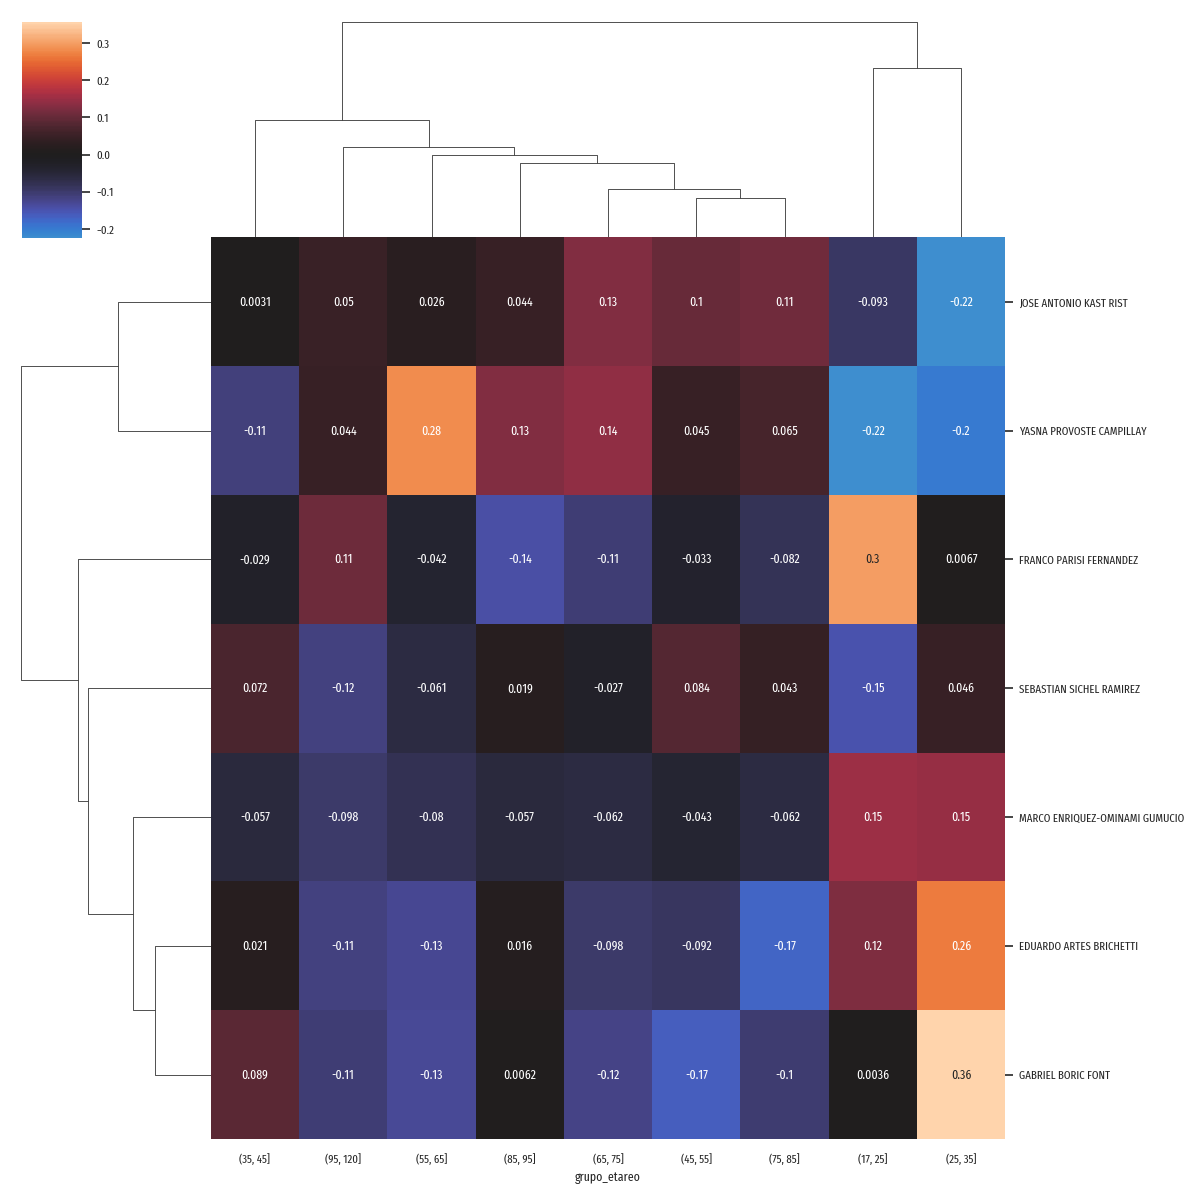

In [29]:
from aves.features.utils import normalize_rows
import seaborn as sns

normalized_turnout = turnout.pipe(normalize_rows)
normalized_edad = comunas_x_edad.pipe(normalize_rows)


sns.clustermap(
    normalized_turnout.join(normalized_edad)
    .corr()
    .loc[normalized_turnout.columns, normalized_edad.columns], center=0, annot=True
)

**Propuesto**: hacer algo similar con la CASEN 2017 (tabla `casen_comunas`).